# Playing Atari with Deep Reinforment Learning
#### The goal of the agent is to interact with the game by selecting actions s.t. maximises the (discounted) future rewards. 

    E[R_0]= r_{0}+ γ*r_{1}+ γˆ2*r_{2} …… = E[∑t=0->n γ^t * r_{t+1}]
    
Defining the optimal policy as among all available actions at the current state, then choose the action that maximizes the expectated total R: 

    Q*(s,a) = max(π) E[R_t |s_t=s, a_t=a, π]
if we assign the computation of successor states' reward R to some orcle V(s), now the expected value under optimal strategy following an important identity known as _Bellman equation_ becomes: 

    chooses a s.t. a = argmax(a') [E(r_t + γ*V(s_{t+1}))]



The basic idea behind reinformance learning algo is to estimate the action value function by using the _Bellman equation_ above as iterative upate to Q_{i+1}(s,a). And such value iteration will eventually converge to the optimal action value function

Here, we use a neural network Q-network to replace the oracle V to compute the action-value function, also as the generalization of the iterative update of totoal q values over a sequence of state and actions. Combined with the _Bellman equaition_ introduced above, this will give us the expected state action value to be the immediate reward plus the discounted accumulated value of the sucessor states as: 

      Q*(s,a) = E [r_t + γ*max(a')Q(s', a')|s, a]




In [46]:
import gym
from gym import envs
from gym import wrappers

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import argparse
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from network.DQN import DQN
from network.deepNet import net




# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


In [2]:

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
DoubleTensor = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor
Tensor = FloatTensor


config = {
            "frame_size_h": 9,
            "frame_size_w": 9,
            "frame_size_d": 3,
            "action_list_n": 83,
            "EPS_START": 1,
            "EPS_END": 0.1,
            "EPS_DECAY": 200,
            "BATCH_SIZE": 32,
            "GAMMA": 0.999,     
            "learning_rate": 1e-4,
            "replay_memory_capacity": 5000,
            "n_itr" : 50,
            
        }

config_net = {
            "hidden_dim": 100
            "hidden_n": 5
}


# named tuple representing a single transition in enviornment
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))
epoch_durations = []
average_total_Q = []
average_total_reward = []


In [3]:

def plot_durations():
    fig = plt.figure(figsize=(6,12))
    plt.clf()
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)   
    reward_t = torch.FloatTensor(average_total_reward)
    q_t = torch.FloatTensor(average_total_Q)

    ax1.plot(reward_t.numpy())
    ax2.plot(q_t.numpy())
    # Take 100 episode averages and plot them too
    #if len(durations_t) >= 100:
    #    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #    means = torch.cat((torch.zeros(99), means))
     #   plt.plot(means.numpy())
        
    ax1.set_title('Training Go9x9-v0')
    ax2.set_title('Training Go9x9-v0')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Average Reward per Epoch')
    ax2.set_ylabel('Average Action value(Q)')

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory =[]
        self.position = 0

    def save(self, *args):      # save a trasition
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position]=Transition(*args)
        self.position= (self.position+1) % self.capacity


    def sample(self, batch_size):       # select random batch of transitions from memory
        return np.random.sample(self.memory, batch_size)


    def __len__(self):
        return len(self.memory)



The algorithm follows off-policy but epsilon controlled greedy strategy, where there is a probaility of epsilon value that action selected by the model (with the estimated max Q value) and select random action with proablity (1-epsilon).


During training, after each episode of interaction with the game enviornment (collect reward, and the next state by taking some action), we will push a transition T = { s_{t}, reward, action, s_{t+1} } to the _replay memory D_ and we sample a batch of transitions from memory when we optimize our network and compute the following:

- the **state action value** estimated by model Q (s_t, a_t),  
- the **expected action state value** y_i (also the target/label) estimated by model max(a')[Q(s',a')|s,a], with Bellman equation this giving us: 

        y_i = Es'->end[ r + gamma * max(a')Q(s',a')|s, a ]
        
  note that in terminal state where V(s)=0, here Q(s_{t-1}, a) = rt


Loss is applied on the differece of predicted and expected by mean square error loss function

In [4]:
class QLearningAgent(object):
    """
    Agent implementing Deep Q-learning with experience replay
    """

    def __init__(self, observation_space, action_space, learnable=None, replay_memory_capacity=None):
        self.observation_space = observation_space
        self.action_space = action_space
        self.epoch_done = 0


        #// initialize replay memory D to capacity N
        self.replay_memory = ReplayMemory(replay_memory_capacity if replay_memory_capacity is not None else config["replay_memory_capacity"])

        #// initialize Q network

        if learnable is not None:
            self.q = DQN(config["frame_size_h"],config["frame_size_w"], \
                         config["action_list_n"]) if learnable=='DQN' \
                    else \
                    net(config["frame_size_h"]*config["frame_size_w"]*config["frame_size_d"], \
                                             config["action_list_n"], config_net["hidden_dim"],\
                                               config_net["hidden_n"])
            #self.q.float()
             
            self.optimizer = optim.RMSprop(self.q.parameters())
            #self.optimizer = optim.SGD(self.q.parameters(), lr=config["learning_rate"], momentum=0.9, weight_decay=0.0001)
            
        else:
            self.q = None


    def act_random(self):
        return self.action_space.sample(), 0


    #  Epsilon greedy control off-policy strategy
    def act_learn(self, observation, eps=None):
        if eps is None:
            eps= config["EPS_END"] + (config["EPS_START"]-config["EPS_END"]) * \
                math.exp(-1. *  self.epoch_done / config["EPS_DECAY"])

        # Compute Q-values for each action
        # pick the action that maximizes Q or random action 
        qvalue_list = self.q(
            Variable(observation,volatile=True).type(FloatTensor)).data  
        
        if np.random.random() > eps:
            qvalue, action = torch.max(qvalue_list, 1)
        else: 
            action = self.action_space.sample()
            qvalue = qvalue_list[action]
            

        return action, qvalue



    def train(self, env):

        self.epoch_done=0

        for i in range(config["n_itr"]):
            print('')
            print(' ---------------------------- Epoch ' + str(self.epoch_done))

            obs = env.reset()          
            reward_total=0.
            qvalue_total=0.

            for t in count():
                print(' episode: ' + str(t+1))
                
                # Select and perform the action
                action, qvalue = self.act_random() if self.q is None else self.act_learn(torch.from_numpy(obs))
                print ('action: ' + str(action) + '\nQ-value: ' + str(qvalue))
                obs2, reward, done, info = env.step(action)               
                print (reward, done, info)

                # Store transition into memory
                if done: 
                    obs2 = None
                self.replay_memory.save(obs ,action, reward, obs2)

                # Perform on step of optimization to Q net
                if self.q is not None:
                    self.optimize_model()


                reward_total += reward
                qvalue_total += qvalue               
                obs = obs2

                if done:
                    average_total_reward.append(reward_total/(t+1))
                    average_total_Q.append(qvalue_total/(t+1))
                    epoch_durations.append(t+1)
                    plot_durations()
                    break


            self.epoch_done += 1

        print('Complete')
        env.render(close=True)
        env.close()
        plt.ioff()
        #plt.show()


    def optimize_model(self):

        BATCH_SIZE = config["BATCH_SIZE"]
        if len(self.replay_memory) < BATCH_SIZE:
            return

        transitions = self.replay_memory.sample(BATCH_SIZE)

        batch = Transition(*zip(*transitions))
        print ('sample batch from memory...\n')


        # Concatenate the batch elements of each
        # state, action , reward in every transition
        state_batch = Variable(torch.cat(batch.state))
        action_batch = Variable(torch.cat(batch.action))
        reward_batch = Variable(torch.cat(batch.reward))


        # Compute Q(s_t, a) by model
        # the model computes Q(s_t) and we select the columns
        # of actions taken in record
        state_action_values = self.q(state_batch).gather(1, action_batch)
        print (" Q(s_{t}, a)"+ str(state_action_values))


        # We don't want backprop expected action values, volatile shuts down requires-grad
        non_final_next_states = Variable (torch.cat([x for x in batch.next_state
                                                 if x is not None]),
                                      volatile=True)


        # Compute state value V(s_{t+1}) by model for all next states,
        # then select the maxQ value of each:
        #
        ## MAX(a)Q(s_{t+1}, a)
        next_state_values, _ = torch.max(self.q(non_final_next_states), 1)   
        print("V(s_{t+1}): "+str(next_state_values))

        # Compute the expected Q values
        #
        ## Bellman equation
        ## Q_{t+1}(s,a) = r + gamma * MAX(a')Q(s', a')
        expected_state_action_values = (next_state_values * config["GAMMA"]) + reward_batch
        print(expected_state_action_values)


        # Compute Mean-Square Error loss from Q and expected Q*
        #
        ## loss(x, y) = 1/n sum|x-y|^2
        loss = torch.nn.MSELoss(state_action_values, expected_state_action_values)
        print(loss)

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()





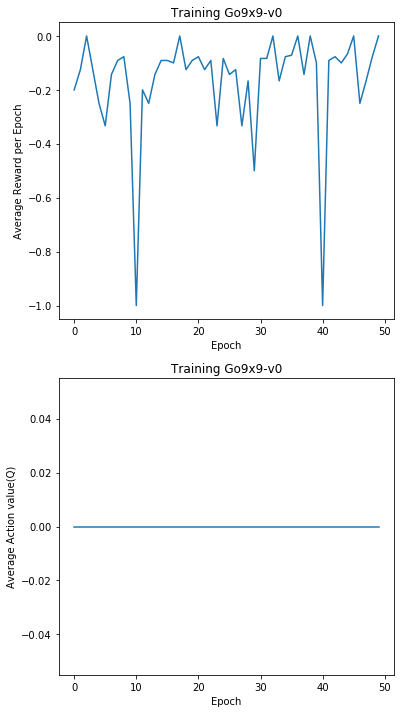

Complete


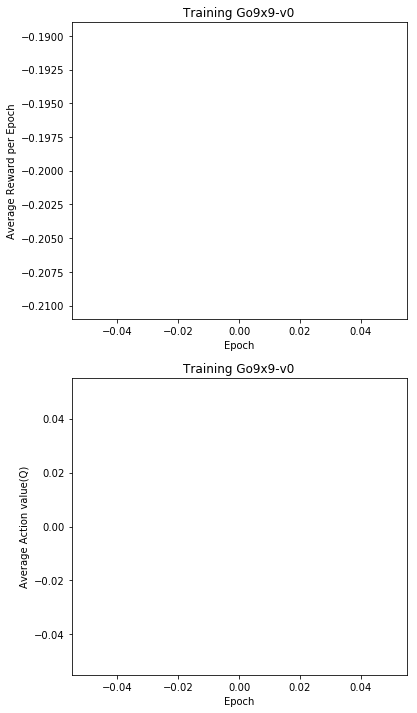

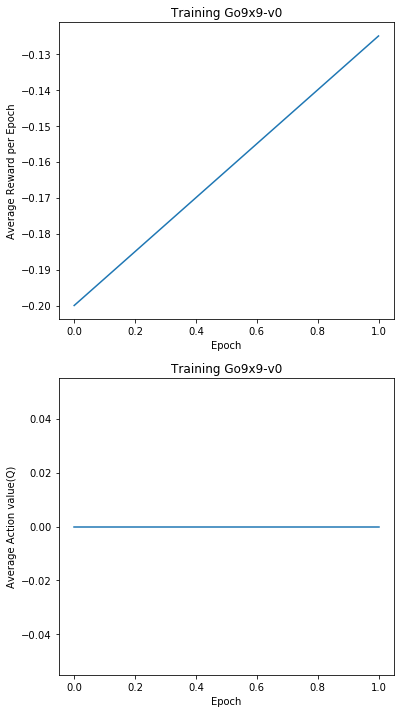

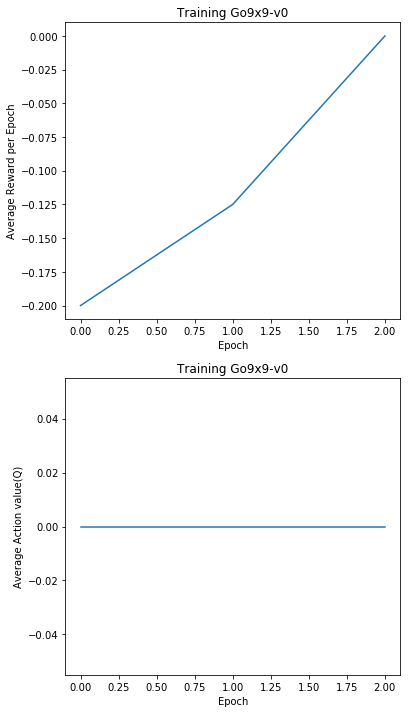

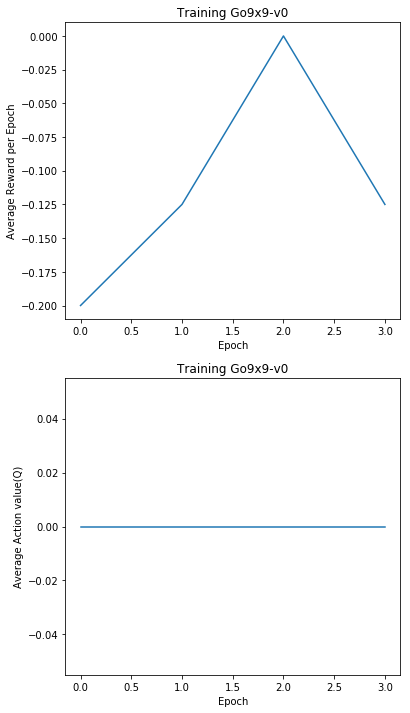

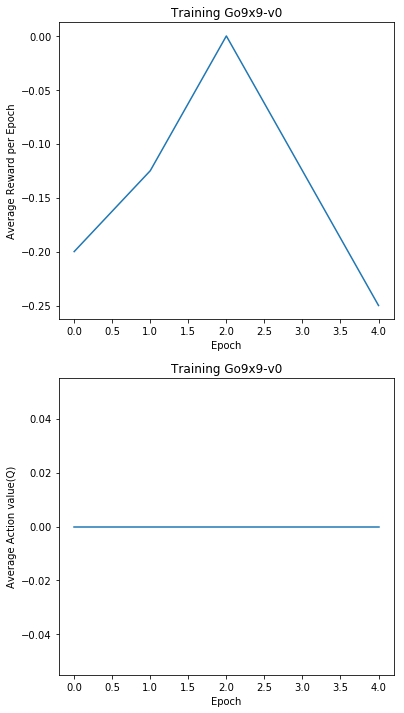

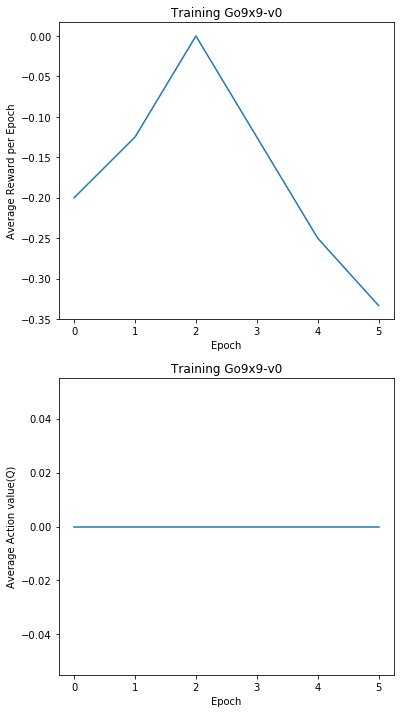

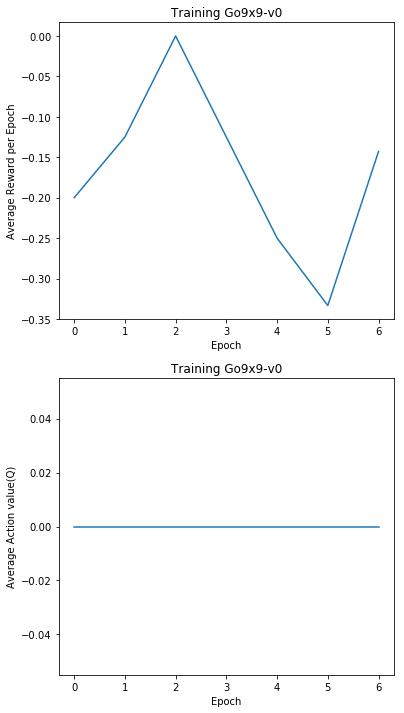

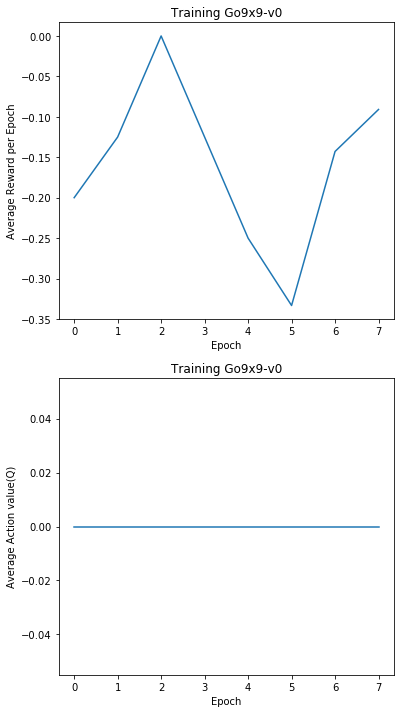

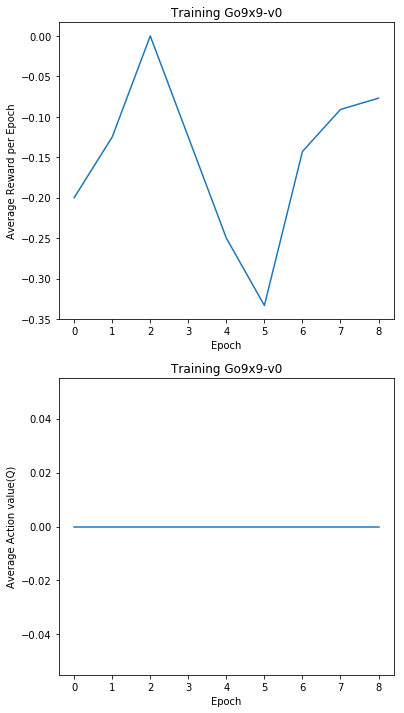

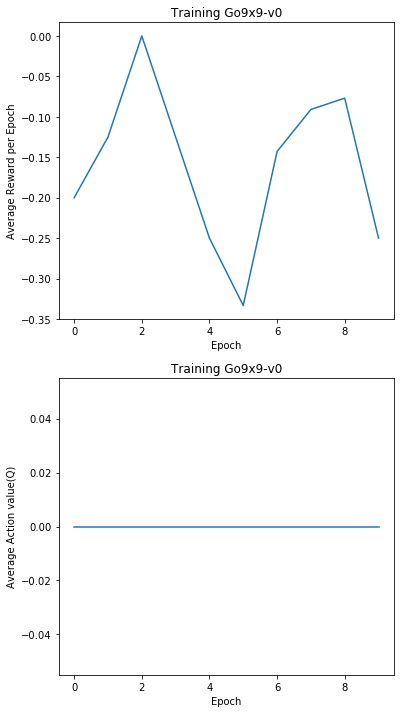

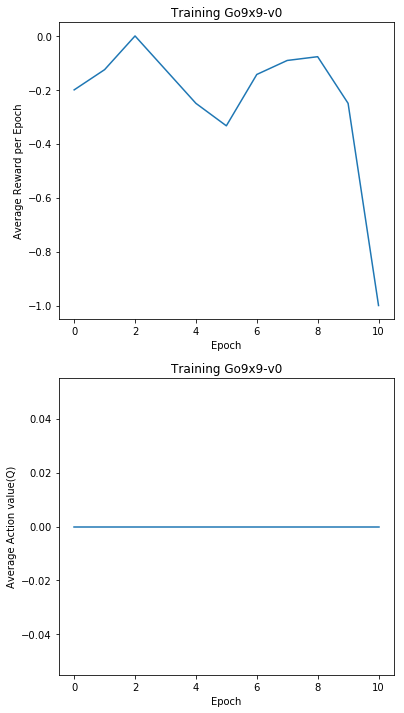

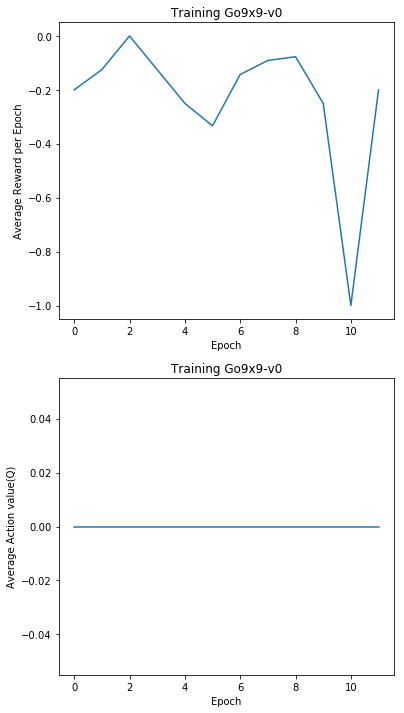

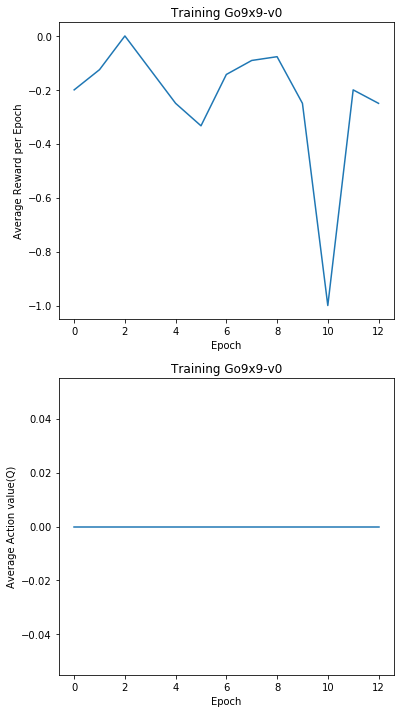

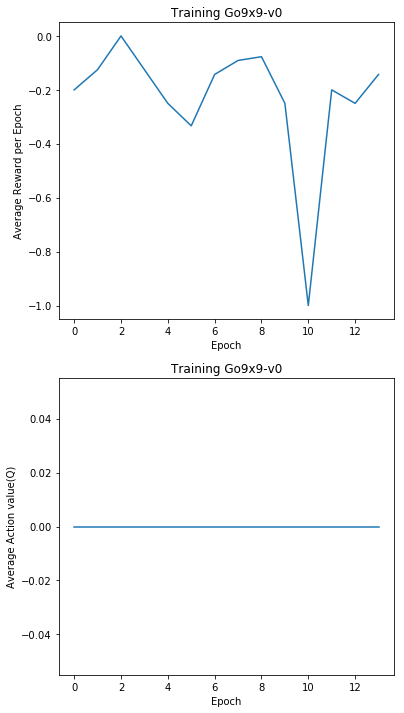

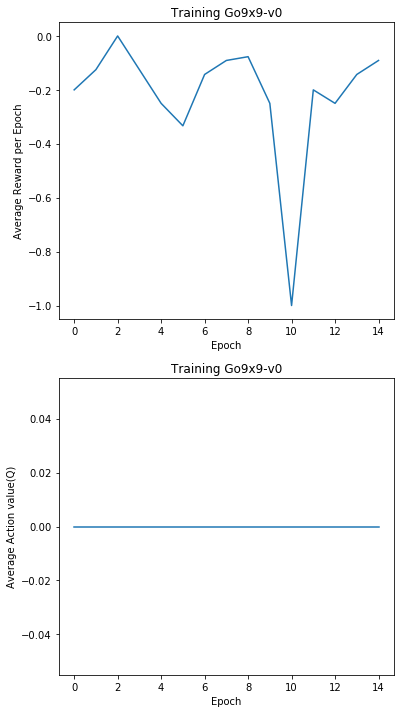

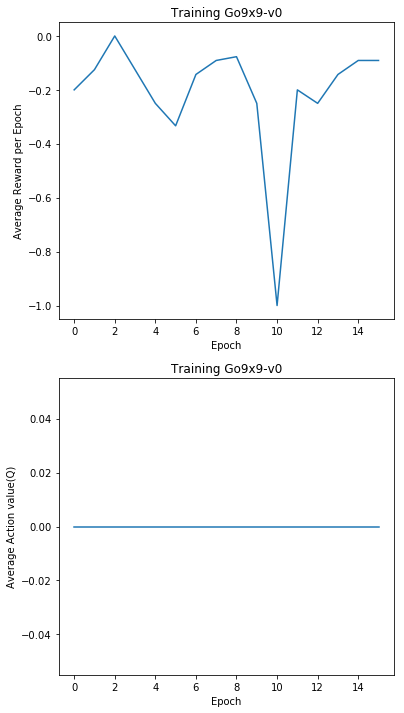

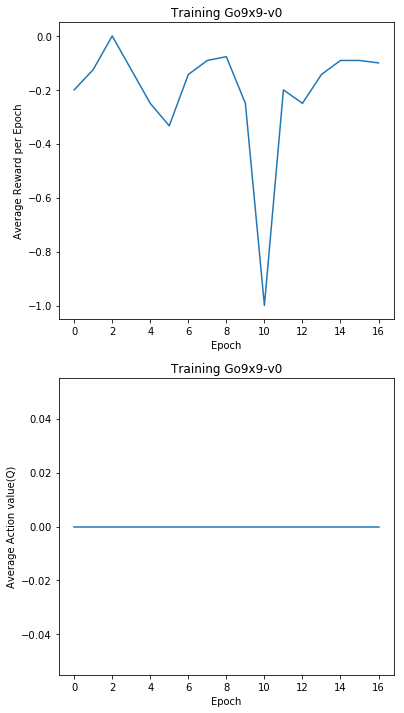

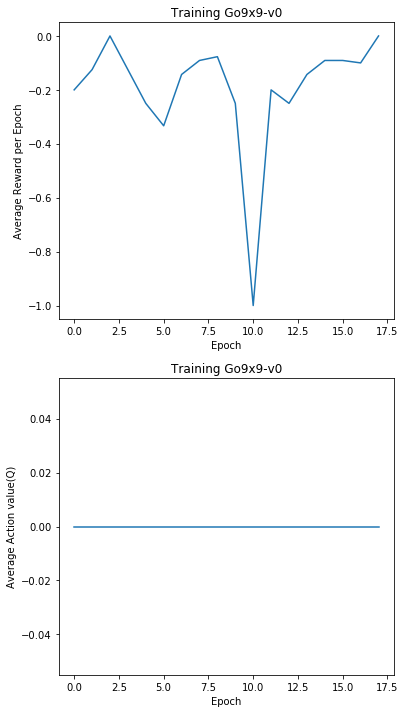

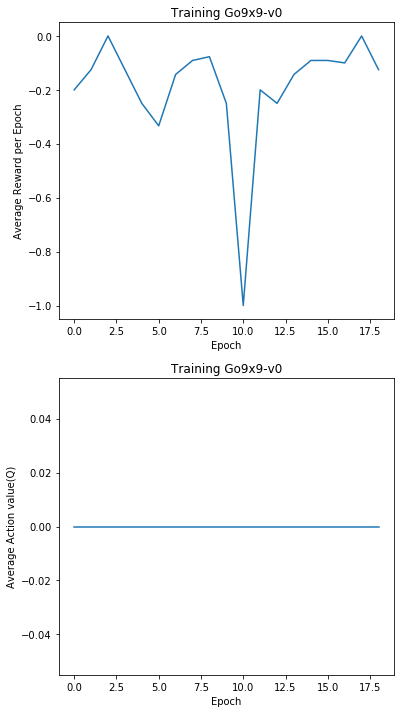

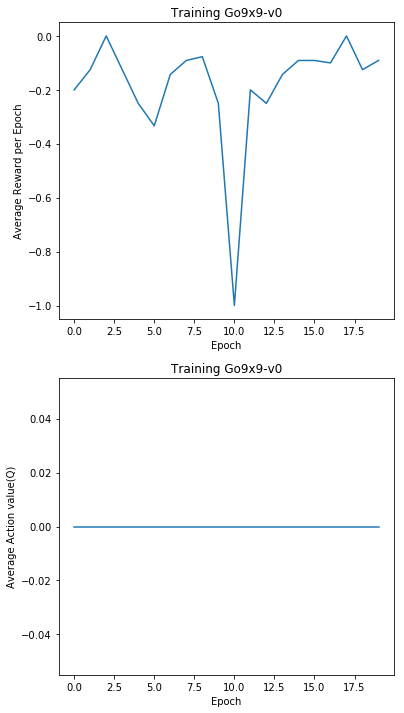

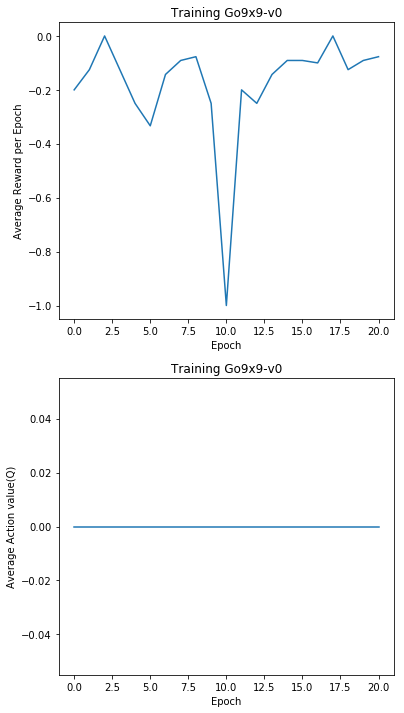

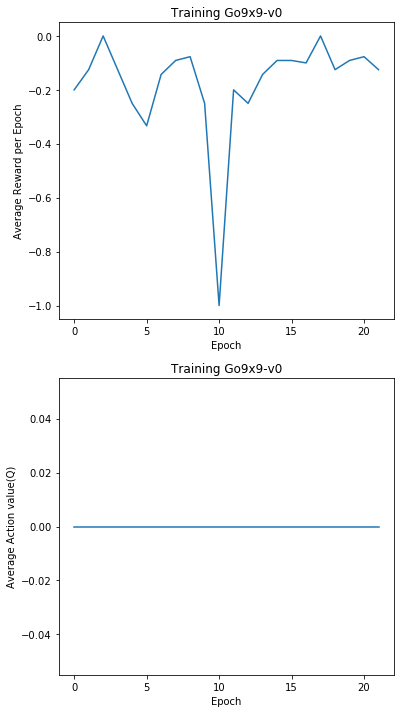

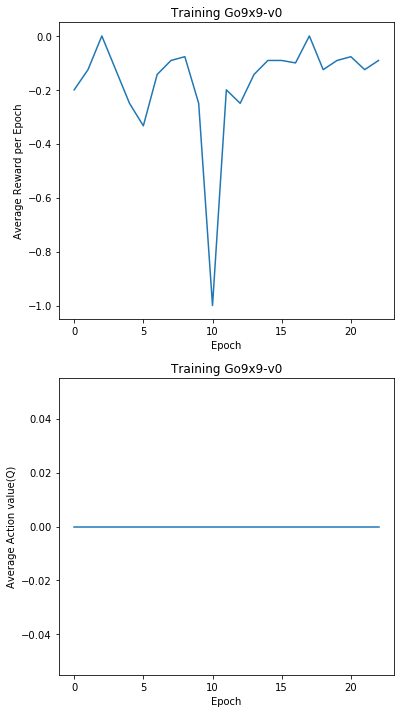

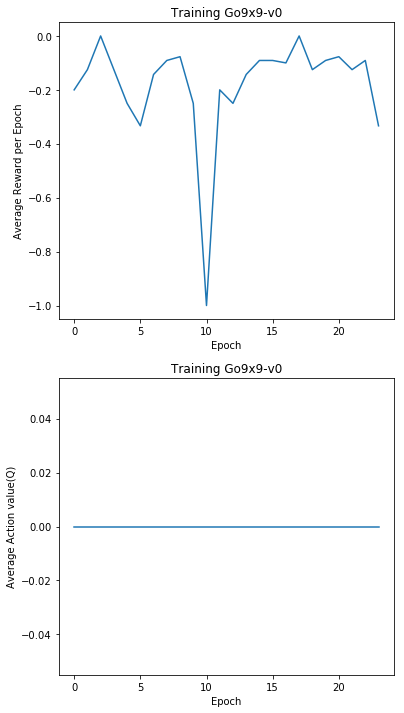

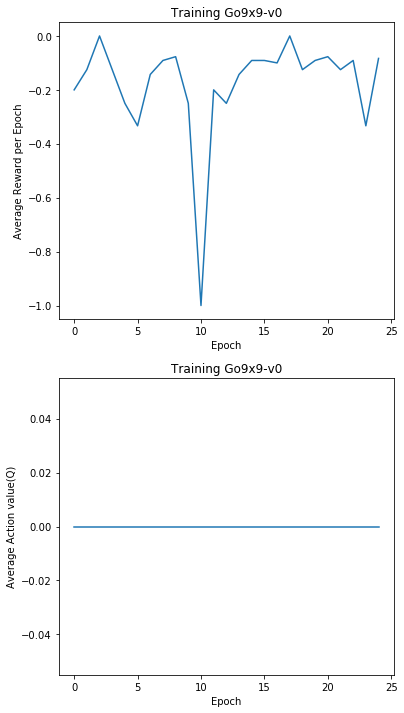

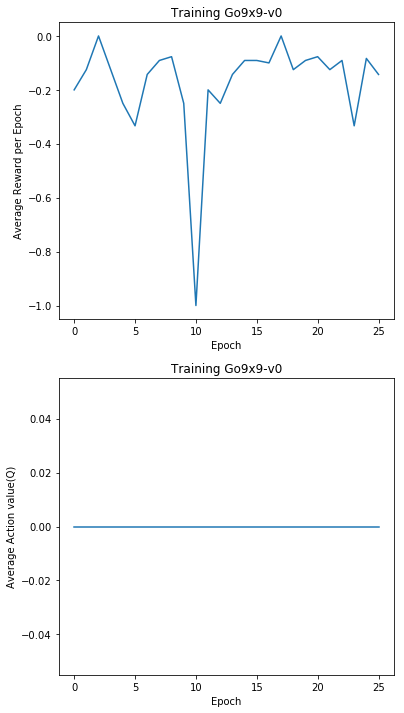

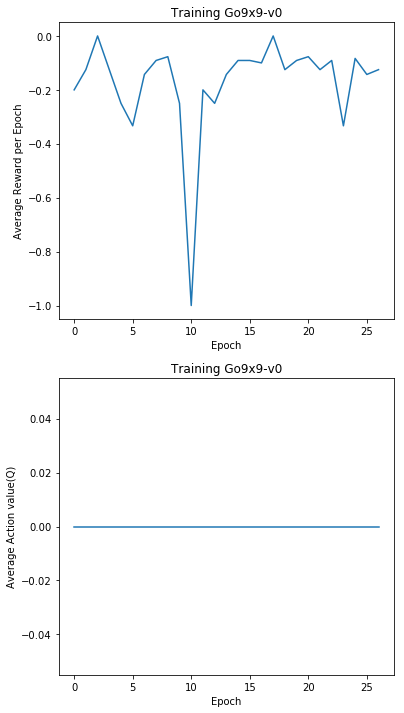

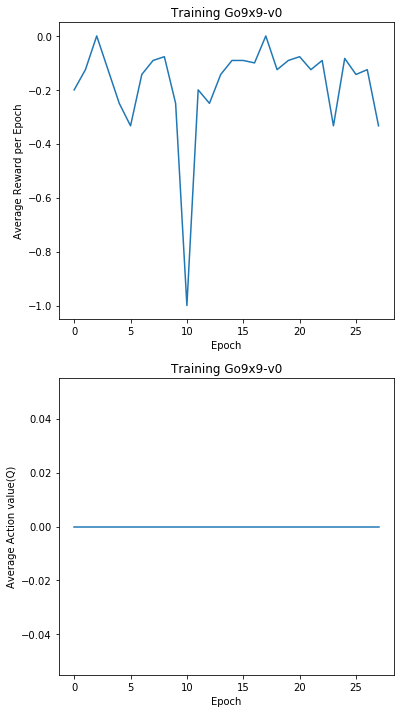

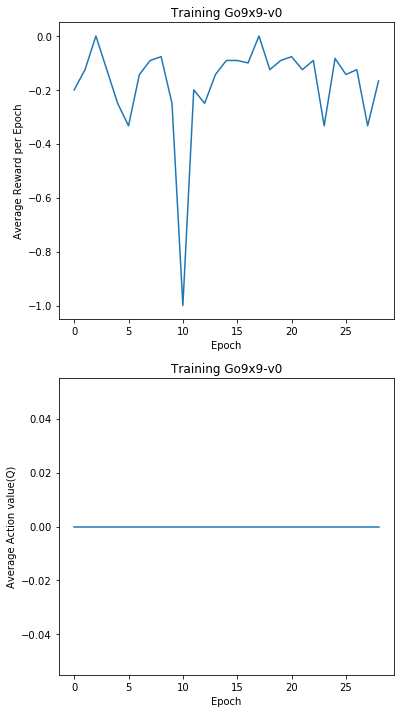

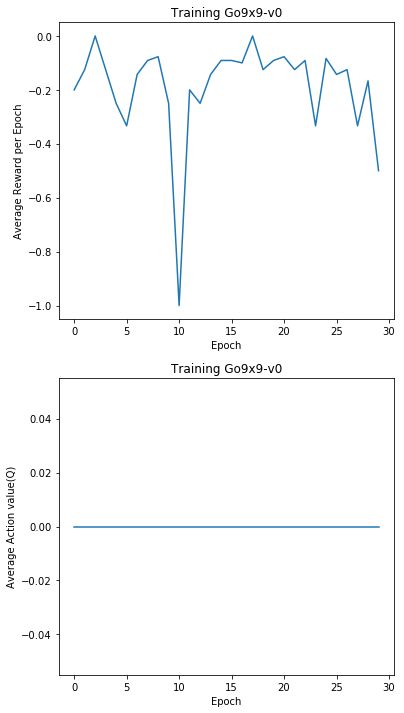

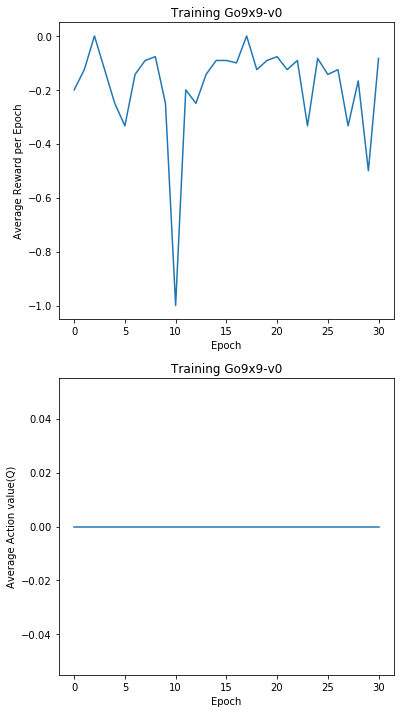

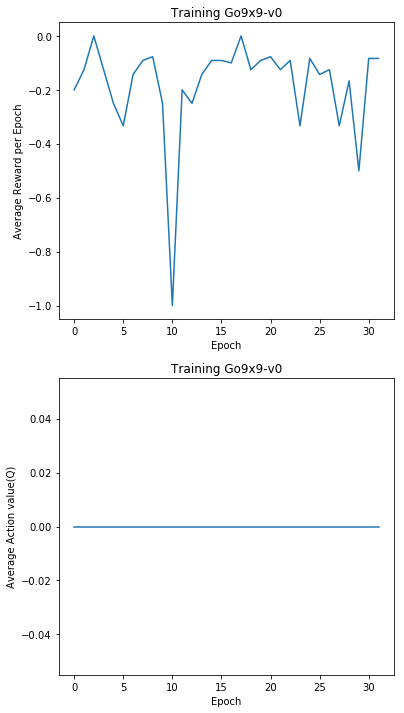

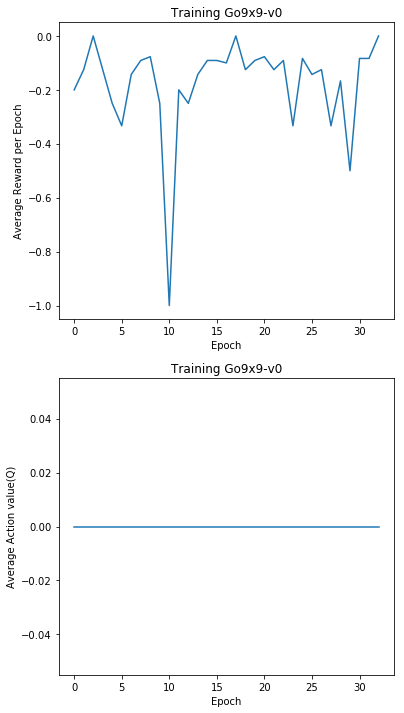

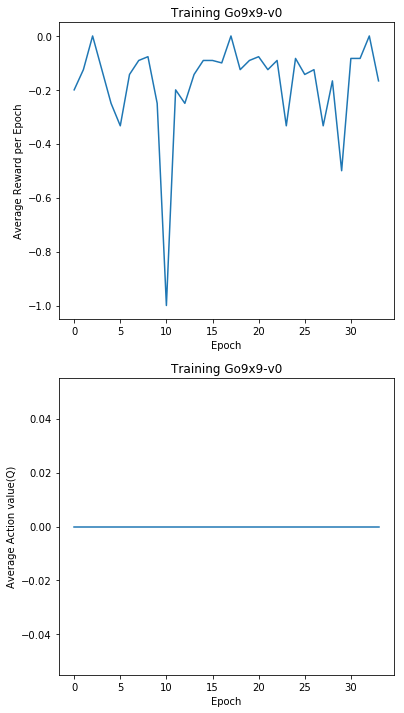

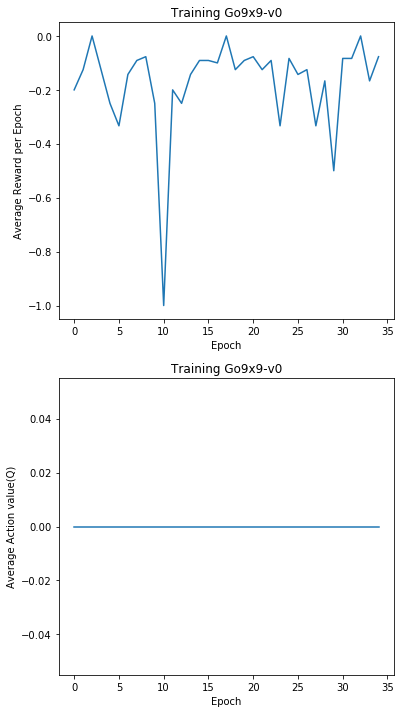

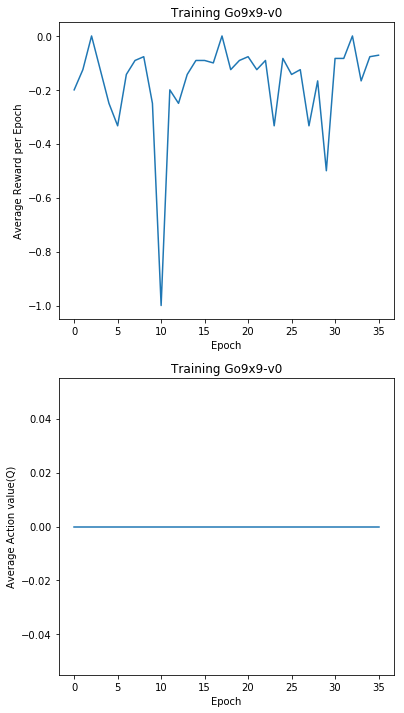

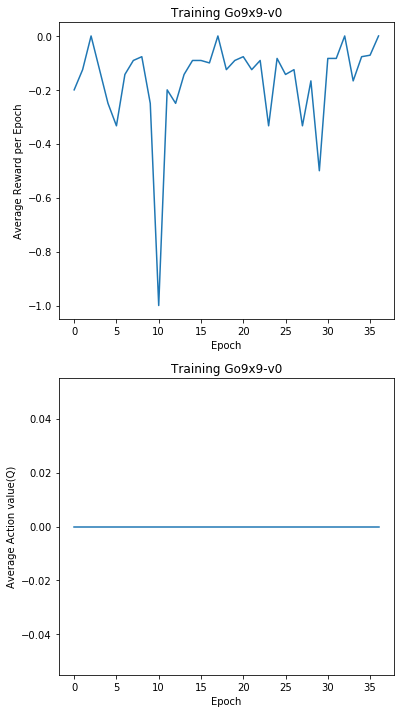

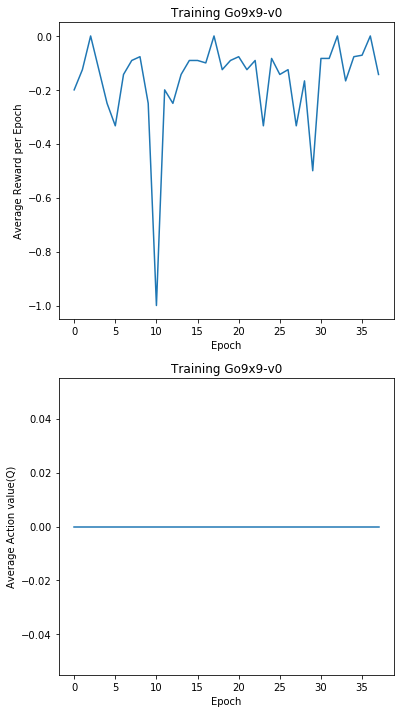

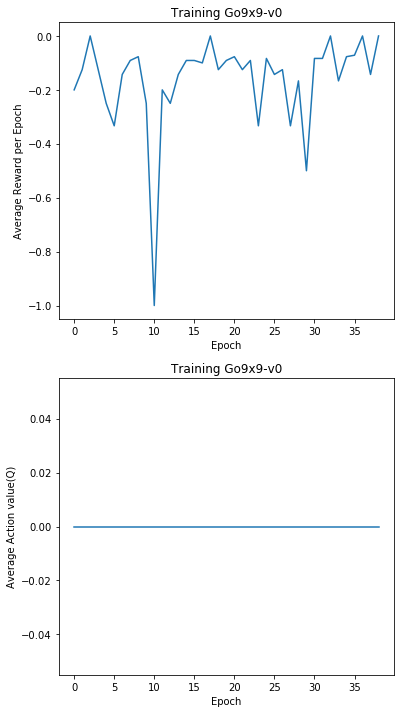

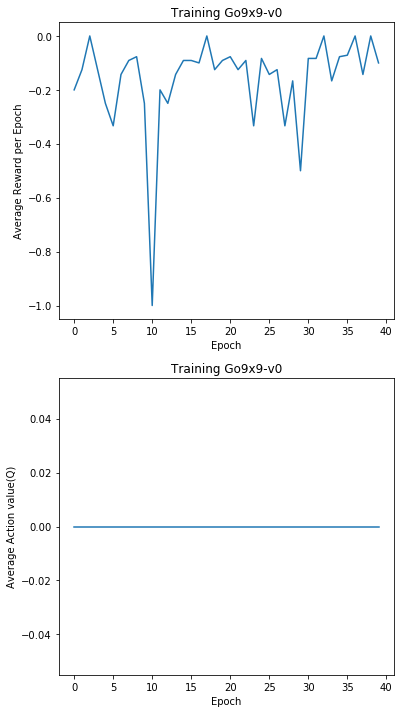

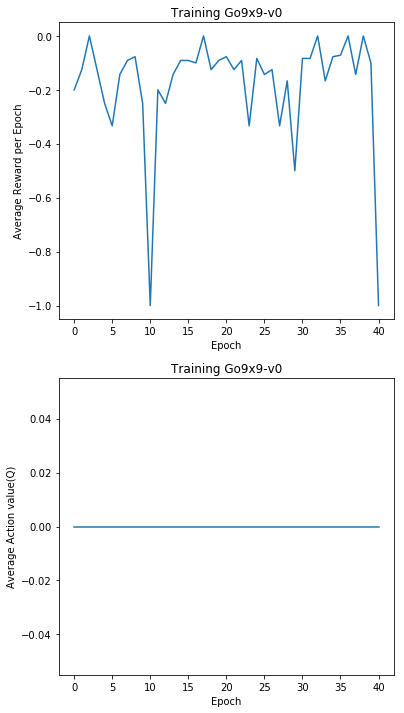

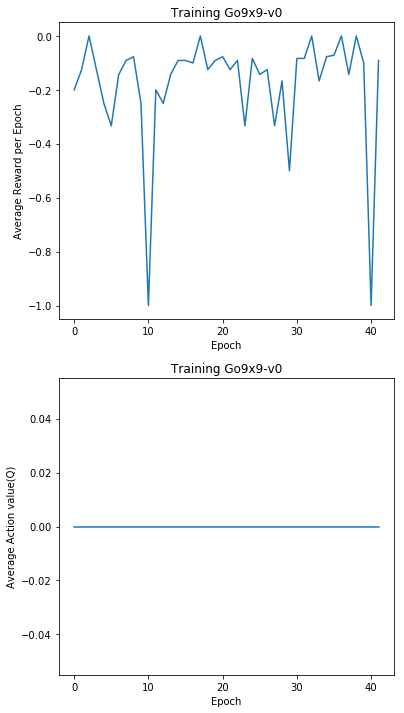

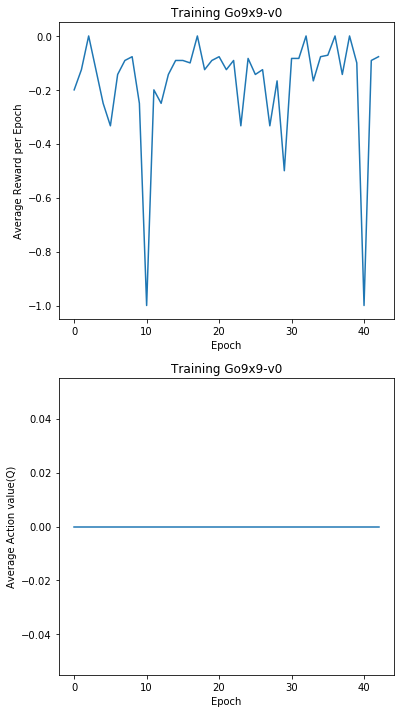

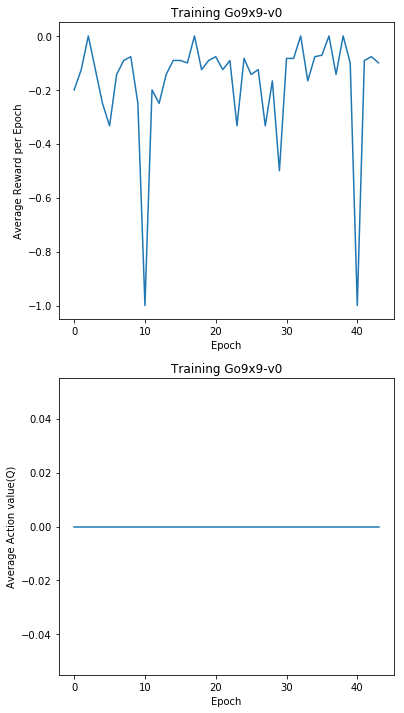

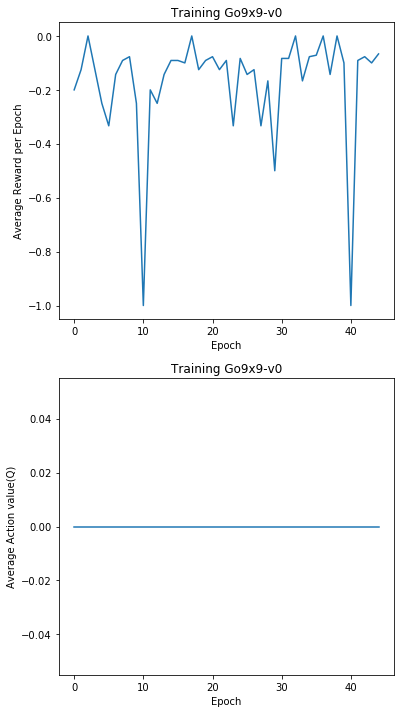

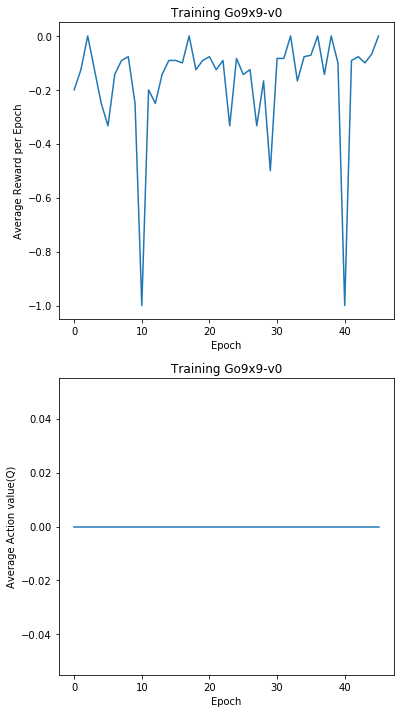

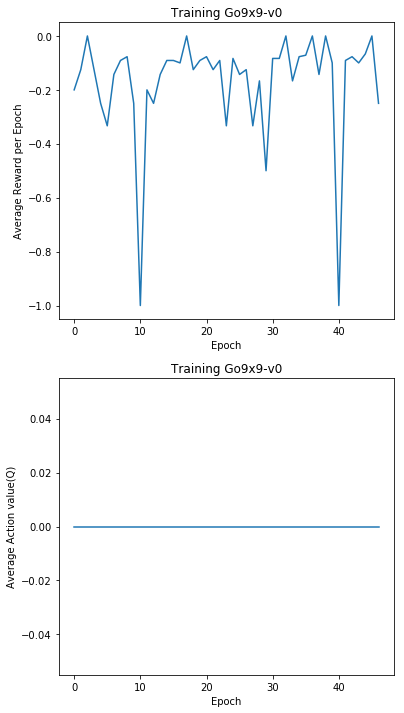

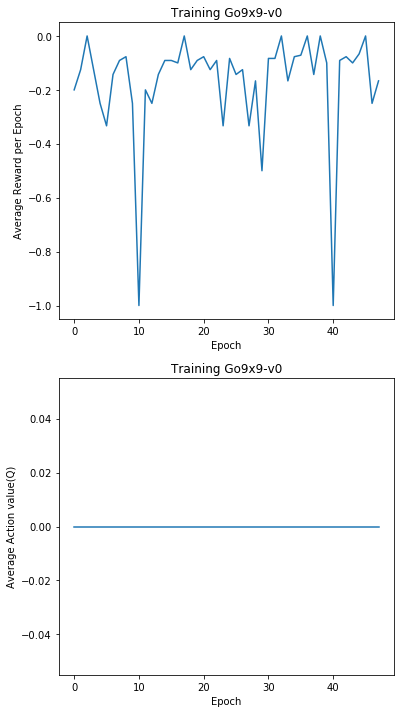

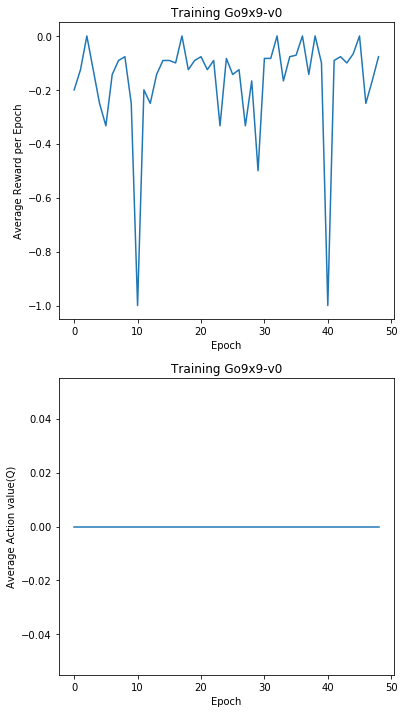

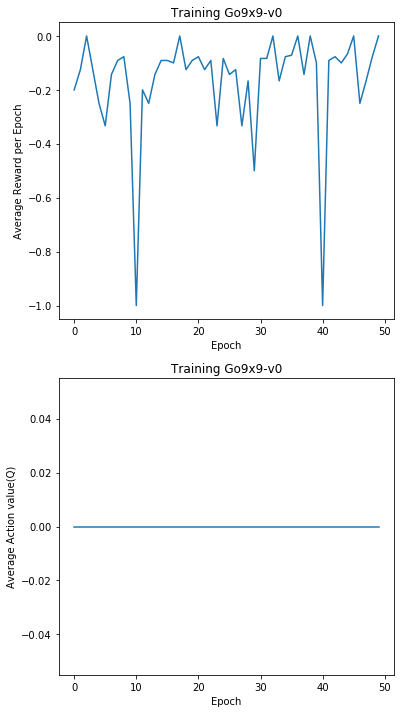

In [5]:
#logger = logging.getLogger()
#logger.setLevel(logging.INFO)

#print(envs.registry.all())

#parser = argparse.ArgumentParser()
#parser.add_argument('--display', action='store_true')
#parser.add_argument('target', nargs="?", default='Go9x9-v0')
#args = parser.parse_args()

env = gym.make('Go9x9-v0')

random_agent = QLearningAgent(env.observation_space, env.action_space)
random_agent.train(env)





In [6]:
Qagent = QLearningAgent(env.observation_space, env.action_space, learnable='deepNet')
Qagent.train(env)


 ---------------------------- Epoch 0
 episode: 1


TypeError: addmm_ received an invalid combination of arguments - got (int, int, torch.FloatTensor, torch.DoubleTensor), but expected one of:
 * (torch.FloatTensor mat1, torch.FloatTensor mat2)
 * (torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
 * (float beta, torch.FloatTensor mat1, torch.FloatTensor mat2)
 * (float alpha, torch.FloatTensor mat1, torch.FloatTensor mat2)
 * (float beta, torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
 * (float alpha, torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
 * (float beta, float alpha, torch.FloatTensor mat1, torch.FloatTensor mat2)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mint[0m, [32;1mtorch.FloatTensor[0m, [31;1mtorch.DoubleTensor[0m)
 * (float beta, float alpha, torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [31;1mtorch.DoubleTensor[0m)


In [47]:
import torch.nn as nn
import torch.nn.functional as F

class net(nn.Module):
    """
        Simple multiple layer net, with 5 hidden layers
        each equipped with rectified non-linearity.
        
    """
    
    def __init__ (self, input_dim, output_dim, hidden_dim, hidden_n=5):
        super(net, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        self.hidden_n = hidden_n
        self.input_dim = input_dim
                   
        
    def forward(self, x):
        assert x.data.size()[1]* x.data.size()[2]* x.data.size()[3] == self.input_dim
        x = x.view(-1, self.input_dim)
        
        x = F.relu(self.input_layer(x))
        for i in range(self.hidden_n):
            x = F.relu(self.hidden_layer(x))
        x = F.relu(self.output_layer(x))
        
        return x
        
        
        
        
inputs = np.random.randn(32,3,9,9).astype('float32')
inputs = Variable(torch.from_numpy(inputs))
print inputs.data.size()
print inputs.view(-1, 9*9*3)
net = net(81*3, 100, 84)
outputs = net(inputs)


torch.Size([32, 3, 9, 9])
Variable containing:
 0.0027  0.3374 -0.5326  ...  -1.3694  1.2851  0.6013
-1.1127 -0.1795 -0.2659  ...   0.7894  0.2894 -0.0143
 0.4952  0.0022  1.5236  ...  -0.0148 -0.4395 -1.1583
          ...             ⋱             ...          
-0.2913 -0.1789 -1.1408  ...   0.8657 -0.2529  0.7848
-0.0204  1.1482  0.4462  ...  -0.6165 -0.9872  1.3897
 0.5997 -0.4281 -1.9981  ...   0.2291 -0.7858  0.6612
[torch.FloatTensor of size 32x243]



TypeError: addmm_ received an invalid combination of arguments - got (int, int, torch.FloatTensor, torch.DoubleTensor), but expected one of:
 * (torch.FloatTensor mat1, torch.FloatTensor mat2)
 * (torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
 * (float beta, torch.FloatTensor mat1, torch.FloatTensor mat2)
 * (float alpha, torch.FloatTensor mat1, torch.FloatTensor mat2)
 * (float beta, torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
 * (float alpha, torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
 * (float beta, float alpha, torch.FloatTensor mat1, torch.FloatTensor mat2)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mint[0m, [32;1mtorch.FloatTensor[0m, [31;1mtorch.DoubleTensor[0m)
 * (float beta, float alpha, torch.SparseFloatTensor mat1, torch.FloatTensor mat2)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [31;1mtorch.DoubleTensor[0m)
